LC ladder: N=40, L_sec=8.750e-10 H, C_sec=3.500e-13 F


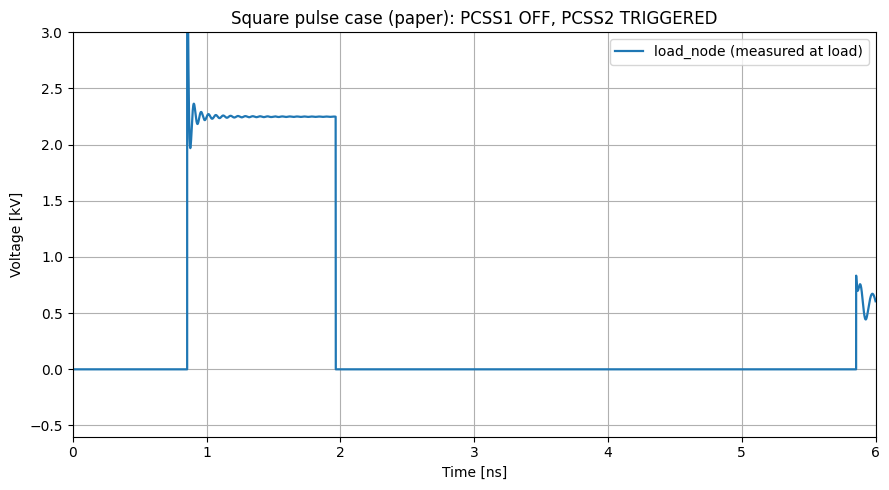

In [4]:
# PySpice: square-pulse (paper) - single LC-ladder line, PCSS1 OFF, PCSS2 ON
# Paste into a Jupyter cell. Requires PySpice + ngspice on PATH.
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parameters (paper values / tuned) ----------------
V_batt = 4500.0       # V (4.5 kV)
R_bias = 1e3          # 1 kΩ charging resistor (as in paper)
Z0 = 50.0             # characteristic impedance (Ω)
TD = 0.7e-9           # transmission delay (s)
N_sections = 40       # LC ladder sections (increase for better TL approximation)
RON = 0.05            # ON resistance of PCSS when triggered (Ω)
ROFF = 1e9            # OFF resistance of PCSS (Ω)
Vt_switch = 2.5       # switch threshold for the V-controlled switch (V)

# control pulse: only drives PCSS2 (right-side switch) to produce the square pulse
# tune delay and width so plateau ~0.85 ns -> ~1.95 ns
ctrl_pulse = 'PULSE(0 5 0.85n 0.01n 0.01n 1.1n 5n)'

# Derived LC per-section values (lossless approx)
tau = TD / N_sections
L_sec = Z0 * tau
C_sec = tau / Z0
print(f'LC ladder: N={N_sections}, L_sec={L_sec:.3e} H, C_sec={C_sec:.3e} F')

# ---------------- Build circuit ----------------
circuit = Circuit('paper_square_pulse_single_line')

# Battery + charging resistor (precharge left end)
circuit.V('batt', 'vbatt', circuit.gnd, V_batt @ u_V)
circuit.R('rbias', 'vbatt', 'node_bias', R_bias @ u_Ohm)

# We'll create an LC ladder from node_bias (left) -> ... -> tx_right (right)
# The load will be connected to a node 'load_node' via the PCSS2 switch when triggered.

# Two 4-terminal PCSS switches:
# - PCSS1: between node_bias and ground (kept OFF)
# - PCSS2: between tx_right and load_node (driven by ctrl_pulse)
# Create control source (only one pulse needed) on 'ctrl' node
circuit.V('ctrl', 'ctrl', circuit.gnd, ctrl_pulse)

# Add PCSS1 raw S element (left switch), NC+ = some controller (we leave it low so it's OFF)
# Use a dummy control 'ctrl_off' that remains 0 V (never triggers)
# We'll create a DC source of 0 V named ctrl_off to avoid undefined node
circuit.V('ctrl_off', 'ctrl_off', circuit.gnd, 0 @ u_V)

raw_s1 = "s1 node_bias 0 ctrl_off 0 sw_left\n"   # s1 N+ N- NC+ NC- model
raw_s2 = "s2 tx_right load_node ctrl 0 sw_right\n" # s2 N+ N- NC+ NC- model

# raw_spice handling: some PySpice versions use string, others a list
if isinstance(circuit.raw_spice, str):
    circuit.raw_spice += raw_s1
    circuit.raw_spice += raw_s2
else:
    circuit.raw_spice.append(raw_s1.strip())
    circuit.raw_spice.append(raw_s2.strip())

# Define switch models (simple SW models)
# Use conservative parameters; ngspice may warn on unknown fields but will run
circuit.model('sw_left',  'SW', RON=ROFF, ROFF=ROFF, Vt=Vt_switch)   # keep left switch OFF by RON=ROFF
circuit.model('sw_right', 'SW', RON=RON,  ROFF=ROFF, Vt=Vt_switch)   # right switch toggles

# Create a small series resistor at left end after switch to stabilize numeric behaviour
circuit.R('rleft', 'node_bias', 'line_in', 0.5 @ u_Ohm)

# Build LC ladder from 'line_in' -> ... -> 'tx_right'
ladder_nodes = ['line_in']
for i in range(1, N_sections+1):
    ladder_nodes.append(f'n{i}')
ladder_nodes[-1] = 'tx_right'   # final node

for i in range(1, len(ladder_nodes)):
    n_prev = ladder_nodes[i-1]
    n_curr = ladder_nodes[i]
    circuit.L(f'L{i}', n_prev, n_curr, L_sec @ u_H)
    circuit.C(f'C{i}', n_curr, circuit.gnd, C_sec @ u_F)

# Load node (isolated until PCSS2 closes)
# RL between load_node and ground (matched 50 ohm)
circuit.R('RL', 'load_node', circuit.gnd, Z0 @ u_Ohm)

# ---------------- Simulation ----------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# run transient with small step
analysis = simulator.transient(step_time=2@u_ps, end_time=6@u_ns)

# ---------------- Safe node getter & plotting ----------------
def get_node(analysis, name):
    # case-insensitive match helper
    keys = list(analysis.nodes.keys())
    if name in analysis.nodes:
        return np.array(analysis.nodes[name])
    for k in keys:
        if k.lower() == name.lower():
            return np.array(analysis.nodes[k])
    print("Available nodes (sample):", keys[:30], '... total', len(keys))
    raise KeyError(f"Node {name} not found")

t = np.array(analysis.time) * 1e9                 # ns
v_load = get_node(analysis, 'load_node') / 1e3    # kV
v_node_bias = get_node(analysis, 'node_bias') / 1e3
v_tx_right = get_node(analysis, 'tx_right') / 1e3

plt.figure(figsize=(9,5))
plt.plot(t, v_load, label='load_node (measured at load)', linewidth=1.6)
#plt.plot(t, v_tx_right, '--', label='tx_right (line right end)', linewidth=1.2)
#plt.plot(t, v_node_bias, ':', label='node_bias (left precharge)', linewidth=1.0)
plt.xlim(0,6)
plt.ylim(-0.6,3.0)
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [kV]')
plt.title('Square pulse case (paper): PCSS1 OFF, PCSS2 TRIGGERED')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
